In [109]:
import gym
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time
import tensorflow as tf

config = tf.ConfigProto()
#config.gpu_options.allow_growth = True

%matplotlib inline
env = gym.make("Pong-v0")

[2017-10-23 18:08:39,631] Making new env: Pong-v0


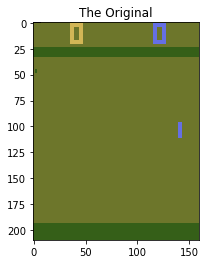

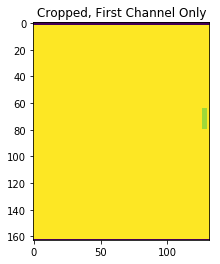

[(53, 396), (101, 64), (109, 21056)]


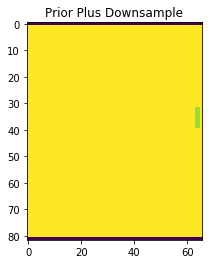

[(53, 132), (101, 16), (109, 5264)]


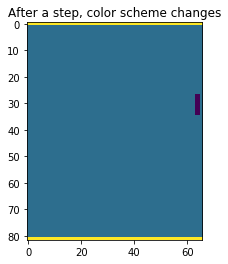

[(92, 16), (144, 5264), (236, 132)]


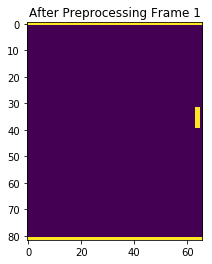

[(0, 5264), (1, 148)]


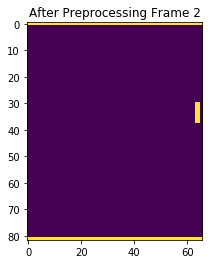

[(0, 5264), (1, 148)]


In [193]:
#what color pixels are in this image?
plt.title("The Original")
plt.imshow(env.reset())
plt.show()

plt.title("Cropped, First Channel Only")
plt.imshow(env.render(mode='rgb_array')[32:195,14:146,0])
plt.show()
print(list(zip(*np.unique(env.render(mode='rgb_array')[32:195,14:146,0],return_counts=1))))

plt.title("Prior Plus Downsample")
plt.imshow(env.render(mode='rgb_array')[32:195,14:146,0][::2,::2])
plt.show()
print(list(zip(*np.unique(env.render(mode='rgb_array')[32:195,14:146,0][::2,::2],return_counts=1))))

plt.title("After a step, color scheme changes")
plt.imshow(env.step(2)[0][32:195,14:146,0][::2,::2])
plt.show()
print(list(zip(*np.unique(env.render(mode='rgb_array')[32:195,14:146,0][::2,::2],return_counts=1))))

def preprocess(img):
    #downsample and crop
    img = img[32:195,14:146,0][::2,::2]
    #get rid of background color
    img[np.isin(img,[144,109])] = 0
    img[img!=0] = 1
    return img.ravel()

def reshape(img):
    return img.reshape(int(np.rint((195-32)/2)),int(np.rint((146-14)/2)))

plt.title("After Preprocessing Frame 1")
plt.imshow(reshape(preprocess(env.reset())))
plt.show()
print(list(zip(*np.unique(reshape(preprocess(env.reset())),return_counts=1))))

plt.title("After Preprocessing Frame 2")
plt.imshow(reshape(preprocess(env.step(2)[0])))
plt.show()
print(list(zip(*np.unique(reshape(preprocess(env.render(mode='rgb_array'))),return_counts=1))))


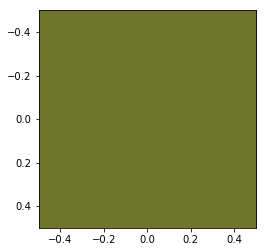

In [161]:
#what color is 109?
img = np.array([[[109,118,43]]], dtype=np.uint8)
plt.imshow(img)
plt.show()

In [168]:
env.render(mode='rgb_array')[:,:,2].shape

(210, 160)

[(0, 24),
 (17, 28984),
 (72, 28984),
 (74, 192),
 (92, 512),
 (130, 192),
 (144, 28984),
 (186, 256),
 (213, 192),
 (236, 12480)]

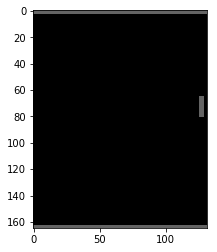

In [114]:
#render()
env.reset()
pixels = env.step(1)[0]
x = np.copy(pixels)
#x[np.isin(x,[17,72,144])] = 0
#x[np.isin(x,[74,92,130,186,213,236])] = 100
def preprocess(img):
    img[np.isin(img,[17,72,144])] = 0
    img[np.isin(img,[74,92,130,186,213,236])] = 100
    return img[31:196,14:146].ravel()
plt.imshow(preprocess(x).reshape((196-31,146-14,3)))
list(zip(*np.unique(pixels,return_counts=1)))

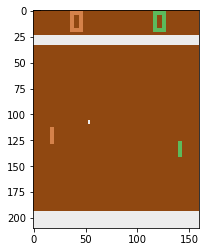

In [106]:
import time

if 0:
    env.reset()
    img = plt.imshow(env.render(mode='rgb_array')[31:196,14:146]) # only call this once
for _ in range(0):
    img.set_data(preprocess(env.render(mode='rgb_array')).reshape((196-31,146-14,3))) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    time.sleep(0.2)
    #the reward element (index 1) is -1 after losing a point, presumably +1 after winning
    print(env.step(action)[1:])
    time.sleep(0.2)
    
env.reset()
for _ in range(50):
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)

In [4]:
env.reset()
print(env.action_space)
env.unwrapped.get_action_meanings()

Discrete(6)


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

(0.0, False, {'ale.lives': 0})


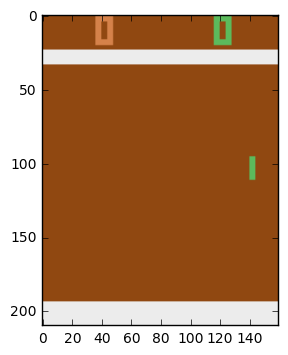

In [4]:
#1 does nothing, 2 goes up, 3 goes down
print(env.step(1)[1:])
render()
plt.show()

KeyboardInterrupt: 

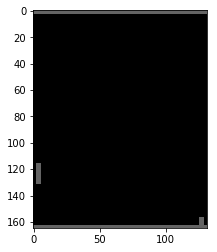

In [16]:
input_dim = (196-31)*(146-14)*3

x = tf.placeholder(tf.float32, shape=[None, input_dim])
y = tf.placeholder(tf.float32, shape=[None, 1])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def preprocess(img):
    img[np.isin(img,[17,72,144])] = 0
    img[np.isin(img,[74,92,130,186,213,236])] = 1
    return img[31:196,14:146].ravel()

h1_dim = 10
w1 = weight_variable([input_dim, h1_dim])
b1 = bias_variable([h1_dim])
r1 = tf.nn.relu(tf.matmul(x,w1) + b1)
w2 = weight_variable([h1_dim, 1])
b2 = bias_variable([1])
logit = tf.matmul(r1,w2) + b2
move_down_probability = tf.nn.sigmoid(logit)
#choose an action based on this probability, 3=down, 2=up
#action = np.random.binomial(1, move_down_probability) + 2
reward = tf.where(move_down_probability>0.5,
                 y*move_down_probability,
                 -y*move_down_probability)
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(-tf.reduce_sum(reward))

def play_pong(match=0, reset=1):
    frames = []
    frame_changes = []
    if reset:
        frames.append(preprocess(env.reset()))
        frame_changes.append(frames[-1]-frames[-1])
    #play one point
    if not match:
        while True:
            p_down = sess.run(move_down_probability,
                        feed_dict={x: np.array([frame_changes[-1]])})
            #choose an action based on this probability, 3=down, 2=up
            action = np.random.binomial(1, p_down) + 2
            observation, reward, done, info = env.step(action)
            frames.append(preprocess(observation))
            frame_changes.append(frames[-1]-frames[-2])
            if reward:
                break
    #play a whole match
    else:
        pass
    reward = reward * np.array([
                [0.98**k] for k in 
                range(len(frame_changes)-1,-1,-1)])
    return np.array(reward), frames, frame_changes

epochs = 301
monitor = 1

with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        #play Pong with the network, save frames and associated rewards
        reward, frames, frame_changes = play_pong()
        train.run(feed_dict={x: frame_changes, y: reward})
        if i%50==0:
            print(reward[-1], sess.run(w1[400][5]))
            time.sleep(3)
            if monitor:
                game = np.array(frames)
                game = game.reshape((len(game),196-31,146-14,3))
                game[game==1] = 100
                img = plt.imshow(game[0]) # only call this once
                for i in range(len(game)):
                    img.set_data(game[i]) # just update the data
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

In [31]:
p_down = np.array([k*0.1 for k in range(10)])
action = np.random.binomial(1, p_down) + 2
action

array([2, 3, 2, 3, 2, 2, 3, 3, 3, 3])

In [18]:
x = tf.placeholder(tf.float32, shape=[None, input_dim])
y = tf.placeholder(tf.float32, shape=[None, 1])

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

h1_dim = 10
w1 = weight_variable([input_dim, h1_dim])
b1 = bias_variable([h1_dim])
logit = tf.matmul(r1,w2) + b2
move_down_probability = tf.nn.sigmoid(logit)
reward = tf.where(move_down_probability>0.5,
                 y*move_down_probability,
                 -y*move_down_probability)
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(-reward)

# Variables must be initialized by running an `init` Op after having
# launched the graph.  We first have to add the `init` Op to the graph.
init_op = tf.global_variables_initializer()

# Launch the graph and run the ops.
with tf.Session() as sess:
  # Run the 'init' op
  sess.run(init_op)
  # Print the initial value of 'state'
  print(sess.run(state))
  # Run the op that updates 'state' and print 'state'.
  for _ in range(3):
    if _==1:
        sess.run(update1)
        print(sess.run(state))
    sess.run(update2)
    print(sess.run(state))


0
2
3
5
7


In [31]:
z=np.ones(1)
z

array([ 5.])

In [18]:
#learn y = x * 0.1 + 0.3
x_data = np.random.rand(100).astype(np.float32)
y_data = (x_data>0.5).astype(np.float32)

# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but TensorFlow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
logits = W * x_data + b

# Minimize the mean squared errors.
#loss = tf.reduce_mean(tf.square(y - y_data))
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_data, logits=logits)
optimizer = tf.train.AdamOptimizer(0.5)
train = optimizer.minimize(loss)

# Before starting, initialize the variables.  We will 'run' this first.
init = tf.global_variables_initializer()

# Launch the graph.
sess = tf.Session(config=config)
sess.run(init)

# Fit the line.
for step in range(201):
    sess.run(train)
    if step % 20 == 0:
        print(step, sess.run(W), sess.run(b))

# Learns best fit is W: [0.1], b: [0.3]

0 [ 1.28379107] [-0.49999991]
20 [ 9.57364464] [-4.72542286]
40 [ 13.95759296] [-6.84228659]
60 [ 16.55422211] [-8.05457211]
80 [ 18.52279472] [-8.99449253]
100 [ 20.2229538] [-9.79433537]
120 [ 21.76064301] [-10.51799488]
140 [ 23.17978477] [-11.18589306]
160 [ 24.50509071] [-11.80889702]
180 [ 25.75300598] [-12.39570045]
200 [ 26.93569946] [-12.95180702]


In [ ]:
sess = tf.InteractiveSession()

# Create 100 phony x, y data points in NumPy, y = x * 0.1 + 0.3
np.random.seed(1)
x_data = np.random.rand(1).astype("float32")
y_data = (x_data < 0.5).astype("float32")

x = tf.placeholder(tf.float32, shape=[None, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])


# Try to find values for W and b that compute y_data = W * x_data + b
# (We know that W should be 0.1 and b 0.3, but Tensorflow will
# figure that out for us.)
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0, seed=1))
b = tf.Variable(tf.zeros([1]))
logits = W * x_data + b


solo_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                        labels=y_data, logits=logits)
cross_entropy = tf.reduce_mean(solo_cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(cross_entropy)

tf.global_variables_initializer().run()

# Fit the line.
for step in range(10):
    print (step, sess.run(W), sess.run(b), sess.run(logits),
           sess.run(solo_cross_entropy) )
    sess.run(train)


In [250]:
y_data

array([ 1.], dtype=float32)

In [75]:
sess.run(tf.nn.softmax([-1.]))

array([ 1.], dtype=float32)